# Model Performance

In [1]:
# load libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15, 7)

In [2]:
# instantiate
TODAY = dt.datetime.now()
AFTER_DATE = "2022-04-01"
AFTER_ERA = 310

nmr = yf.download('NMR-USD', start=AFTER_DATE, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [3]:
# get model ranking
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance
def get_model_performance(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_submissions_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model round performance aggregated
def get_model_performance_aggregated(score, by):
    df = pd.pivot_table(
        data=perf.groupby(["modelName", by])[score].mean().reset_index(),
        values=score,
        index=[by],
        columns=["modelName"]
    )
    return df

# get model payout & staking history
def get_model_value(model_list, mode):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    df_all = df_all.loc[df_all["roundResolved"]==True]
    
    if mode == "payout":
        mode_value = "payout"
    elif mode == "staking":
        mode_value = "selectedStakeValue"
    else:
        print("Select either 'payout' or 'staking' as mode.")

    output = pd.pivot_table(
        df_all, 
        values=mode_value, 
        index=['roundResolveTime'], 
        columns=['modelName']).fillna(0)
    output["totalValue"] = output.sum(axis=1)

    return output

In [4]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[-1]
nmr_price

17.694780826568604

In [5]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_desperado', 'dh_gaia', 'dh_terra'])

---
# Model Ranks

In [6]:
# get model rankings
rank = get_model_rankings(model_list=model_list)
rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 30
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype                  
---  ------     --------------  -----                  
 0   corrRank   844 non-null    int64                  
 1   corrRep    844 non-null    float64                
 2   date       844 non-null    datetime64[ns, tzutc()]
 3   fncRank    844 non-null    int64                  
 4   fncRep     844 non-null    float64                
 5   fncV3Rank  552 non-null    float64                
 6   fncV3Rep   552 non-null    float64                
 7   mmcRank    844 non-null    int64                  
 8   mmcRep     844 non-null    float64                
 9   tcRank     637 non-null    float64                
 10  tcRep      637 non-null    float64                
 11  modelName  844 non-null    object                 
dtypes: datetime64[ns, tzutc()](1), float64(7), int64(3), object(1)
memory usage: 85.7+ KB


In [7]:
# check model name list
rank["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_skulls', 'dh_desperado', 'dh_gaia', 'dh_terra'], dtype=object)

In [8]:
# cols
tc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and col.startswith("tc")]
tc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and col.startswith("tc")]
nontc_rank_cols = [col for col in rank.columns if col.endswith("Rank") and not col.startswith("tc")]
nontc_rep_cols = [col for col in rank.columns if col.endswith("Rep") and not col.startswith("tc")]

tc_rank_cols, tc_rep_cols, nontc_rank_cols, nontc_rep_cols

(['tcRank'],
 ['tcRep'],
 ['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep'])

---
# Correlation Ranking & Reputation

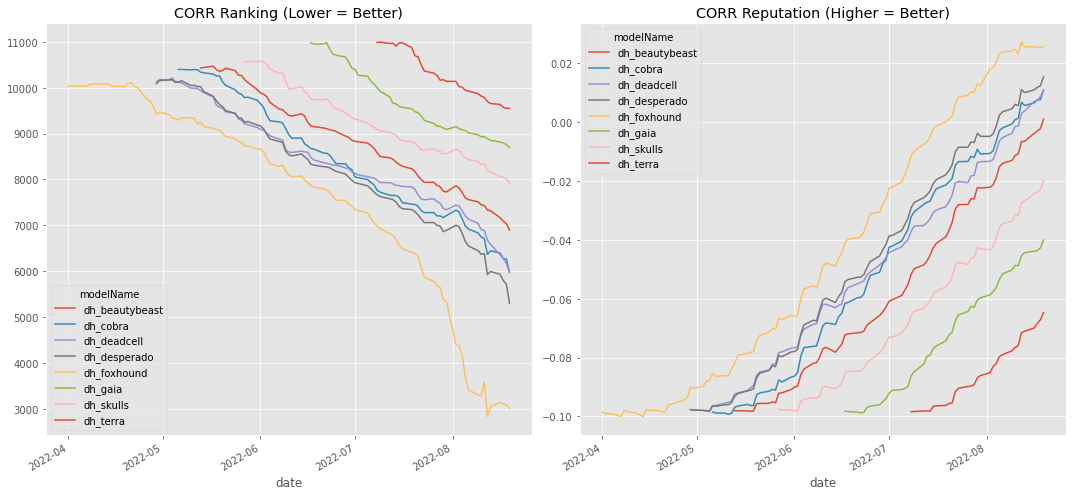

In [9]:
# plot  corr rank and rep
corrdf = rank.loc[rank["date"]>=AFTER_DATE]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("CORR Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("CORR Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/CorrRankPlots.png', facecolor='w')
plt.show()

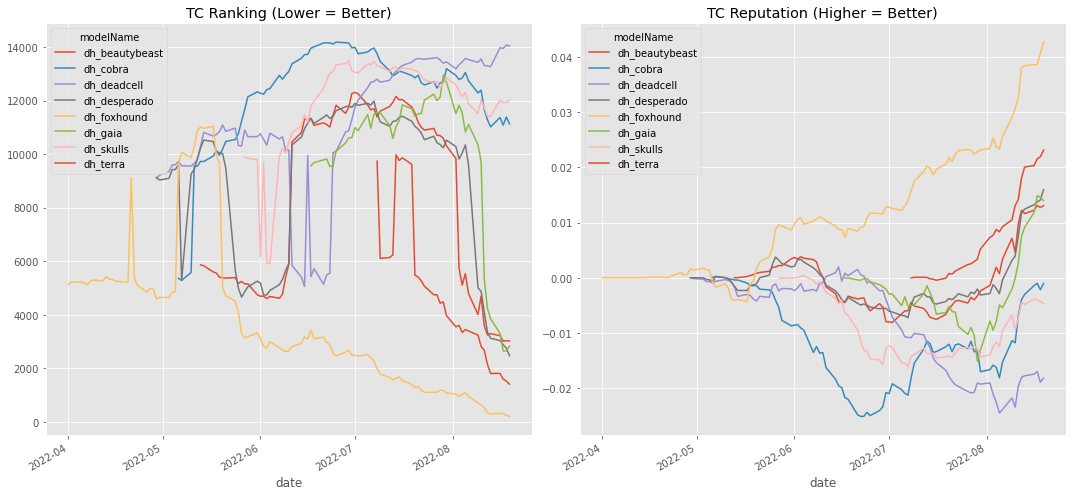

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
pd.pivot_table(
    data=corrdf[["modelName", "date", "tcRank"]],
    values="tcRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("TC Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "tcRep"]],
    values="tcRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("TC Reputation (Higher = Better)")

plt.tight_layout()
plt.savefig('plots/TCRankPlots.png', facecolor='w')
plt.show()

---
# Model Performance by Round

In [11]:
# get round performance
perf = get_model_performance(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2532 entries, 0 to 93
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype                  
---  ------                    --------------  -----                  
 0   corrPercentile            2532 non-null   float64                
 1   correlation               2532 non-null   float64                
 2   correlationWithMetamodel  2532 non-null   float64                
 3   date                      2532 non-null   datetime64[ns, tzutc()]
 4   fnc                       2532 non-null   float64                
 5   fncPercentile             2532 non-null   float64                
 6   mmc                       2532 non-null   float64                
 7   mmcPercentile             2532 non-null   float64                
 8   roundNumber               2532 non-null   int64                  
 9   tc                        1941 non-null   float64                
 10  tcPercentile              1941 non-nul

In [12]:
# performance table
perf.head()

,corrPercentile,correlation,correlationWithMetamodel,date,fnc,fncPercentile,mmc,mmcPercentile,roundNumber,tc,tcPercentile,modelName
0,0.483232,0.040858,0.658749,2021-03-25 00:00:00+00:00,-0.020880,0.060976,0.002185,0.637195,256,NaN,NaN,dh_foxhound
1,0.397851,0.006832,0.658722,2021-03-26 00:00:00+00:00,-0.015211,0.086599,-0.004726,0.425411,256,NaN,NaN,dh_foxhound
2,0.222599,-0.004340,0.658724,2021-03-27 00:00:00+00:00,-0.021847,0.045135,-0.008314,0.273127,256,NaN,NaN,dh_foxhound
3,0.151207,-0.008355,0.658724,2021-03-30 00:00:00+00:00,-0.019505,0.069005,-0.011256,0.142408,256,NaN,NaN,dh_foxhound
4,0.117396,-0.015704,0.658724,2021-03-31 00:00:00+00:00,-0.017714,0.055933,-0.012699,0.118024,256,NaN,NaN,dh_foxhound


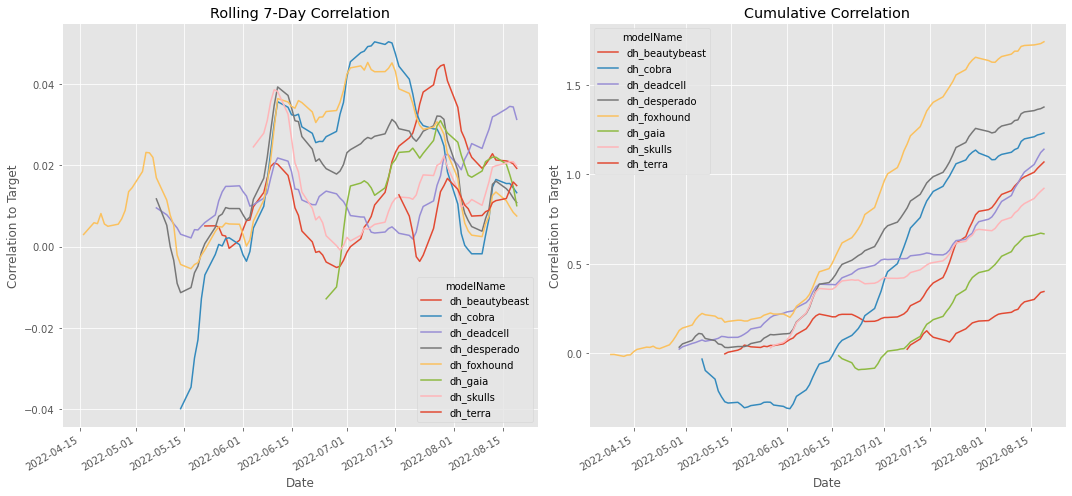

In [13]:
# get mean corr by round
avg_corr_by_era = get_model_performance_aggregated(score="correlation", by="roundNumber")
avg_corr_by_date = get_model_performance_aggregated(score="correlation", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_corr_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_corr_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day Correlation")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Correlation to Target")
axes[1].set_title("Cumulative Correlation")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation to Target")
plt.tight_layout()
plt.savefig('plots/ModelCorrPlots.png', facecolor='w')
plt.show()

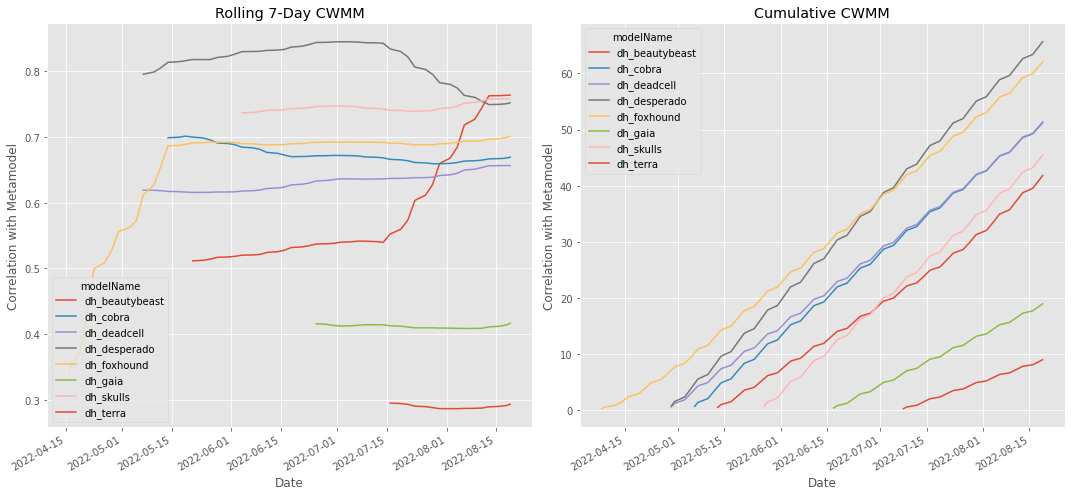

In [14]:
# get mean cwmm by round
avg_cwmm_by_era = get_model_performance_aggregated(score="correlationWithMetamodel", by="roundNumber")
avg_cwmm_by_date = get_model_performance_aggregated(score="correlationWithMetamodel", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_cwmm_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_cwmm_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day CWMM")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Correlation with Metamodel")
axes[1].set_title("Cumulative CWMM")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Correlation with Metamodel")
plt.tight_layout()
plt.savefig('plots/ModelCWMMPlots.png', facecolor='w')
plt.show()

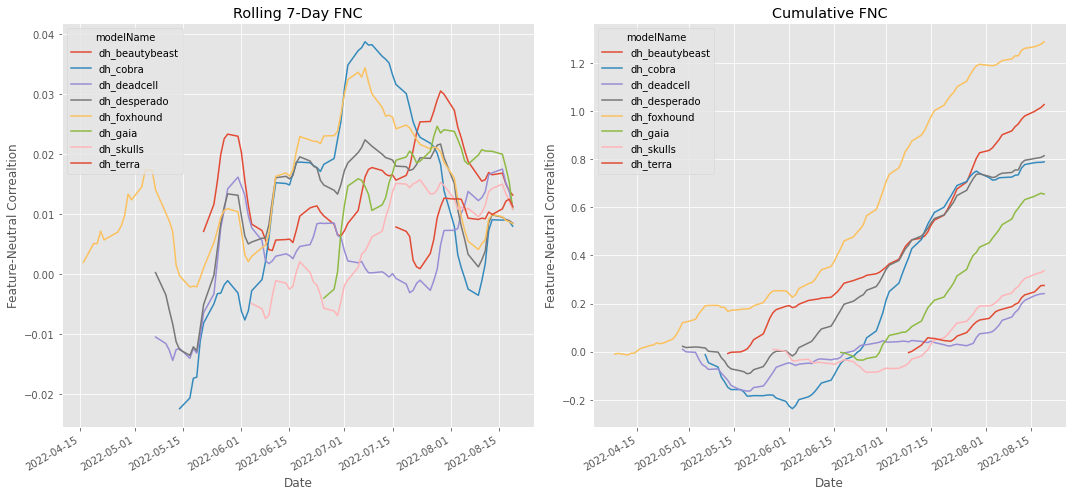

In [15]:
# get mean fnc by round
avg_fnc_by_era = get_model_performance_aggregated(score="fnc", by="roundNumber")
avg_fnc_by_date = get_model_performance_aggregated(score="fnc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_fnc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_fnc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day FNC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Feature-Neutral Correaltion")
axes[1].set_title("Cumulative FNC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Feature-Neutral Correaltion")
plt.tight_layout()
plt.savefig('plots/ModelFNCPlots.png', facecolor='w')
plt.show()

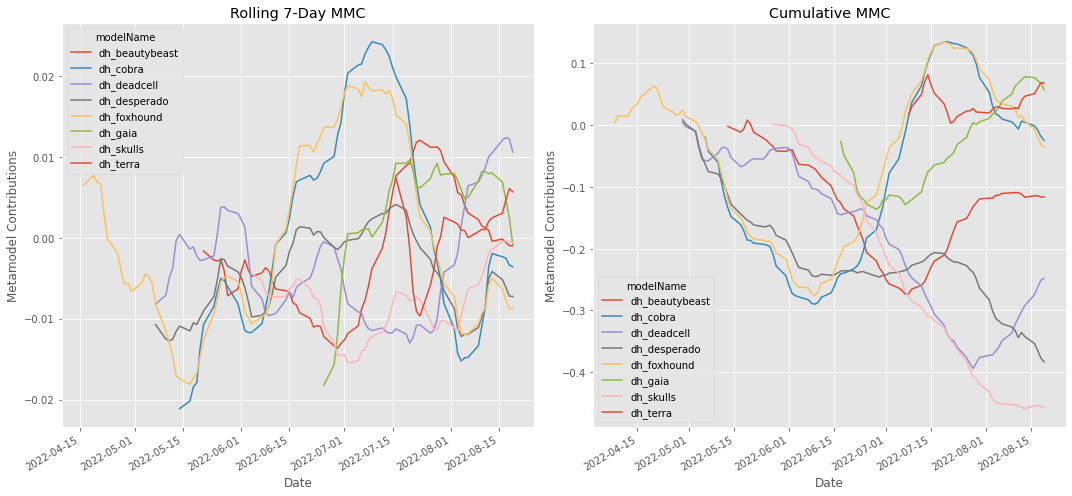

In [16]:
# get mean mmc by round
avg_mmc_by_era = get_model_performance_aggregated(score="mmc", by="roundNumber")
avg_mmc_by_date = get_model_performance_aggregated(score="mmc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_mmc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_mmc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day MMC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Metamodel Contributions")
axes[1].set_title("Cumulative MMC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Metamodel Contributions")
plt.tight_layout()
plt.savefig('plots/ModelMMCPlots.png', facecolor='w')
plt.show()

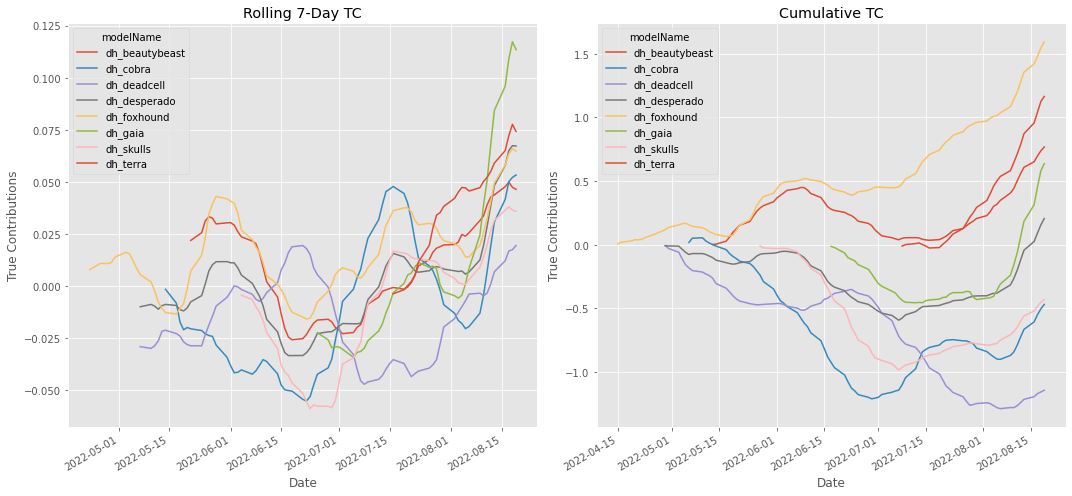

In [17]:
# get mean mmc by round
avg_tc_by_era = get_model_performance_aggregated(score="tc", by="roundNumber")
avg_tc_by_date = get_model_performance_aggregated(score="tc", by="date")

# plot
fig, axes = plt.subplots(nrows=1, ncols=2)
avg_tc_by_date.loc[AFTER_DATE:].rolling(7).mean().plot(ax=axes[0])
avg_tc_by_date.loc[AFTER_DATE:].cumsum().plot(ax=axes[1])
axes[0].set_title("Rolling 7-Day TC")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("True Contributions")
axes[1].set_title("Cumulative TC")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("True Contributions")
plt.tight_layout()
plt.savefig('plots/ModelTCPlots.png', facecolor='w')
plt.show()

---
# Model Payouts & Staking

In [18]:
# get payout
payout = get_model_value(model_list, "payout")
payout.tail()

modelName,dh_beautybeast,dh_cobra,dh_deadcell,dh_desperado,dh_foxhound,dh_gaia,dh_skulls,dh_terra,totalValue
roundResolveTime,,,,,,,,,
2022-07-21 20:00:00+00:00,0.026503,0.062299,-0.039632,0.416407,0.687403,0.000000,0.024029,0.0,1.177009
2022-07-28 20:00:00+00:00,0.024153,0.015278,-0.032808,0.262563,0.566427,0.000000,0.011744,0.0,0.847357
2022-08-04 20:00:00+00:00,0.021179,0.060065,0.010559,0.192813,0.079675,0.013949,0.008628,0.0,0.386867
2022-08-11 20:00:00+00:00,0.018491,0.101643,0.020148,0.086610,0.078596,0.008734,0.013700,0.0,0.327923
2022-08-18 20:00:00+00:00,0.014098,0.086811,0.016226,0.070753,0.052859,0.008532,0.010767,0.0,0.260047


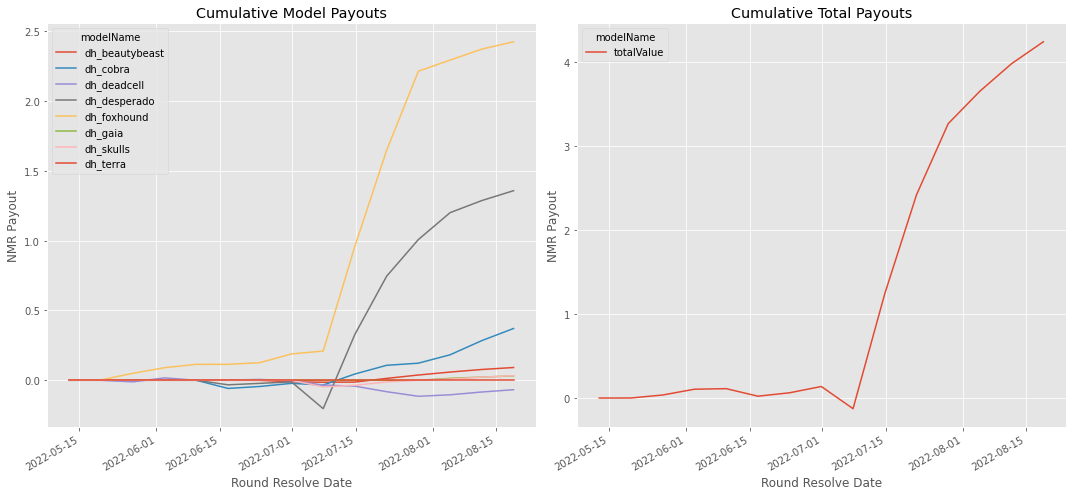

In [19]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2)
payout.loc[AFTER_DATE:][[col for col in payout.columns if col.startswith("dh_")]].cumsum().plot(ax=axes[0])
payout.loc[AFTER_DATE:][["totalValue"]].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Model Payouts")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Payout")
axes[1].set_title("Cumulative Total Payouts")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Payout")
plt.tight_layout()
plt.savefig('plots/PayoutPlots.png', facecolor='w')
plt.show()

In [20]:
# get payout
staking = get_model_value(model_list, "staking")
staking.tail()

modelName,dh_beautybeast,dh_cobra,dh_deadcell,dh_desperado,dh_foxhound,dh_gaia,dh_skulls,dh_terra,totalValue
roundResolveTime,,,,,,,,,
2022-07-21 20:00:00+00:00,1.000000,0.941385,1.001265,14.967372,15.114160,0.0,1.000000,0.0,34.024183
2022-07-28 20:00:00+00:00,0.999667,0.955421,1.005958,14.977791,15.125796,0.0,1.000000,0.0,34.064633
2022-08-04 20:00:00+00:00,0.988733,15.977786,0.995838,14.988445,15.188682,1.0,1.000000,0.0,50.139484
2022-08-11 20:00:00+00:00,0.985849,15.966055,0.965721,14.796388,15.209174,1.0,0.952394,0.0,49.875581
2022-08-18 20:00:00+00:00,0.986897,16.044863,0.957620,15.329371,15.960946,1.0,0.964073,0.0,51.243771


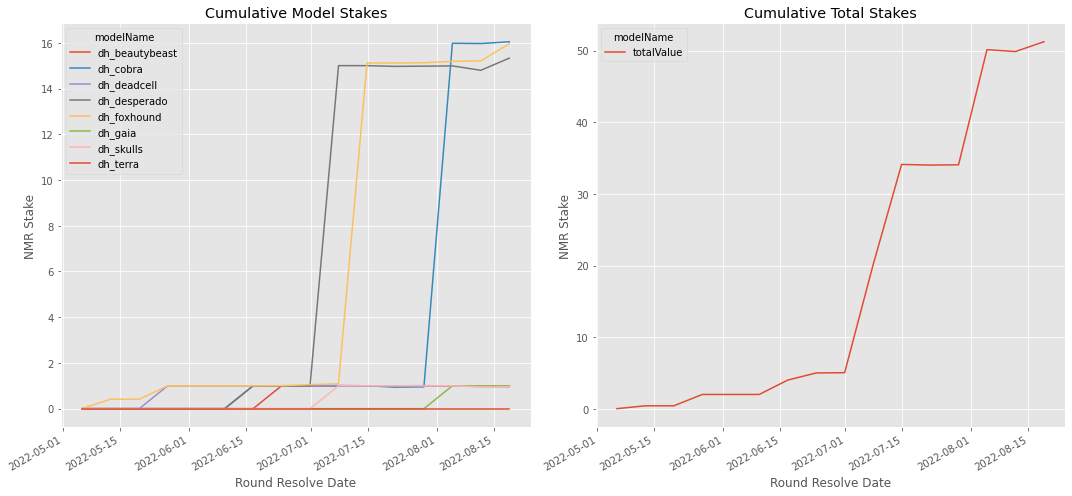

In [21]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2)
staking.loc[AFTER_DATE:][[col for col in staking.columns if col.startswith("dh_")]].plot(ax=axes[0])
staking.loc[AFTER_DATE:][["totalValue"]].plot(ax=axes[1])
axes[0].set_title("Cumulative Model Stakes")
axes[0].set_xlabel("Round Resolve Date")
axes[0].set_ylabel("NMR Stake")
axes[1].set_title("Cumulative Total Stakes")
axes[1].set_xlabel("Round Resolve Date")
axes[1].set_ylabel("NMR Stake")
plt.tight_layout()
plt.savefig('plots/ModelStakingPlots.png', facecolor='w')
plt.show()

---
# Total Return

In [22]:
# get return
total_return = pd.concat([payout.sum(), staking.tail(1).T], axis=1)
total_return.columns = ["payout", "staking"]
total_return["return"] = total_return["payout"] / total_return["staking"]

total_return

,payout,staking,return
modelName,,,
dh_beautybeast,0.091321,0.986897,0.092533
dh_cobra,0.370960,16.044863,0.023120
dh_deadcell,-0.067887,0.957620,-0.070891
dh_desperado,1.358517,15.329371,0.088622
dh_foxhound,2.430357,15.960946,0.152269
dh_gaia,0.031215,1.000000,0.031215
dh_skulls,0.032942,0.964073,0.034170
dh_terra,0.000000,0.000000,NaN
totalValue,4.247425,51.243771,0.082887


In [23]:
# daily staking 
round_return = pd.concat([payout["totalValue"], staking["totalValue"]], axis=1)[AFTER_DATE:].fillna(0)
round_return.columns = ["payout", "staking"]
round_return["return"] = round_return["payout"] / round_return["staking"]

round_return

,payout,staking,return
roundResolveTime,,,
2022-05-05 20:00:00+00:00,0.000000,0.014453,0.000000
2022-05-12 20:00:00+00:00,0.002033,0.414453,0.004906
2022-05-19 20:00:00+00:00,0.000667,0.414453,0.001609
2022-05-26 20:00:00+00:00,0.035571,2.000003,0.017785
2022-06-02 20:00:00+00:00,0.068884,2.000003,0.034442
2022-06-09 20:00:00+00:00,0.006714,2.000003,0.003357
2022-06-16 20:00:00+00:00,-0.089689,4.002037,-0.022411
2022-06-23 20:00:00+00:00,0.040450,5.002704,0.008086
2022-06-30 20:00:00+00:00,0.074851,5.038274,0.014857


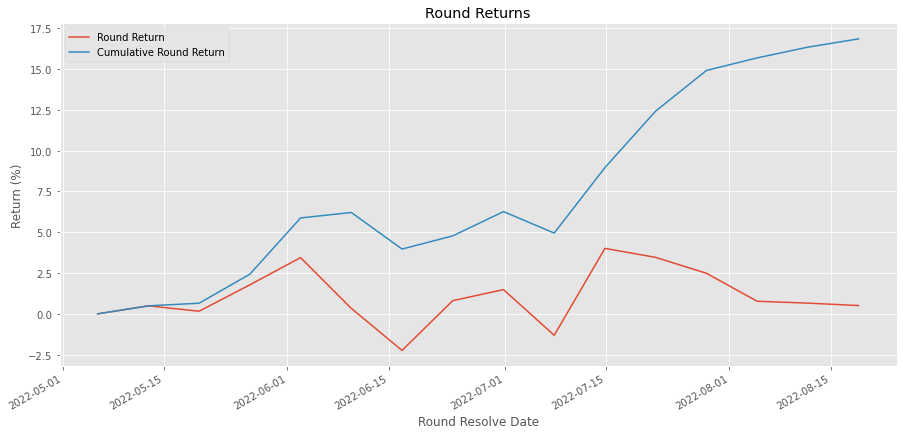

In [24]:
# plot round return
plt.figure()
(round_return["return"] * 100).plot()
(round_return["return"] * 100).cumsum().plot()
plt.legend(["Round Return", "Cumulative Round Return"])
plt.title("Round Returns")
plt.xlabel("Round Resolve Date")
plt.ylabel("Return (%)")
plt.savefig('plots/TotalReturnPlots.png', facecolor='w')
plt.show()

---
# Sharpe Performance

In [25]:
# rank by sharpe on correlation
def get_sharpe(x):
    return x.mean() / x.std()

perf_clean = perf.loc[perf["roundNumber"]>=AFTER_ERA]
corr_sharpe_df = pd.concat([
    perf_clean.groupby("modelName")["correlation"].size(),
    perf_clean.groupby("modelName")["correlation"].apply(lambda x: get_sharpe(x))], 
    axis=1)
corr_sharpe_df.columns = ["n", "sharpe"]
corr_sharpe_df = corr_sharpe_df.loc[corr_sharpe_df["n"]>=10].sort_values("sharpe")

In [26]:
# rank by sharpe on true contribution
perf_clean = perf.loc[perf["roundNumber"]>=AFTER_ERA]
tc_sharpe_df = pd.concat([
    perf_clean.groupby("modelName")["tc"].size(),
    perf_clean.groupby("modelName")["tc"].apply(lambda x: get_sharpe(x))], 
    axis=1)
tc_sharpe_df.columns = ["n", "sharpe"]
tc_sharpe_df = tc_sharpe_df.loc[tc_sharpe_df["n"]>=10].sort_values("sharpe")

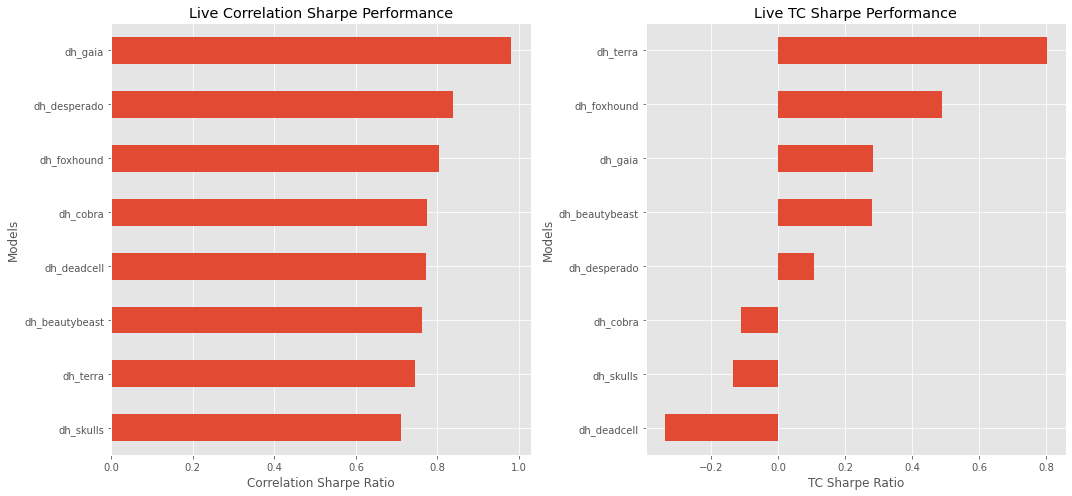

In [27]:
# plot both
fig, axes = plt.subplots(nrows=1, ncols=2)
corr_sharpe_df["sharpe"].plot.barh(ax=axes[0])
tc_sharpe_df["sharpe"].plot.barh(ax=axes[1])
axes[0].set_title("Live Correlation Sharpe Performance")
axes[0].set_xlabel("Correlation Sharpe Ratio")
axes[0].set_ylabel("Models")
axes[1].set_title("Live TC Sharpe Performance")
axes[1].set_xlabel("TC Sharpe Ratio")
axes[1].set_ylabel("Models")
plt.savefig('plots/SharpeRatioPlots.png', facecolor='w')
plt.tight_layout()
plt.show();